In [1]:
import sys
sys.version
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages') # gioia's py35 libraries

In [2]:
from sklearn.neighbors import KernelDensity

from scipy.stats.distributions import norm
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Shared variables

In [3]:
# draw points from a bimodal distribution in 1D
N = 100000

np.random.seed(0) # for consistency across runs
x = np.concatenate([norm(-1, 1.).rvs(int(0.8 * N)),
                    norm(1, 0.3).rvs(int(0.2 * N))])

In [4]:
# the grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# the real PDF of the bimodal distribution
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

In [5]:
kernel = 'gaussian'
bandwidth = 0.2

## Sci-kit learn implementation

In [6]:
def kde_sklearn(x, x_grid, bandwidth, **kwargs):
    '''
    Kernel Density Estimation with Scikit-learn
    Source: http://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
    '''
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

Time to complete model: 5.73 seconds


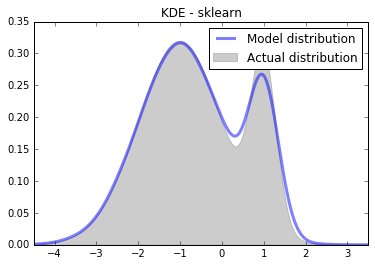

In [7]:
timer = time.time()
pdf = kde_sklearn(x, x_grid, bandwidth=bandwidth, kernel=kernel)
print('Time to complete model: {:.2f} seconds'.format(time.time() - timer))

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3, label='Model distribution')
plt.fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4, label='Actual distribution')
plt.title('KDE - sklearn')
plt.legend(loc='best')
plt.xlim(-4.5, 3.5)
plt.show()

## Naive Python implementation

In [8]:
def gaussian(x):
    '''
    Returns the Gaussian function for the input x variable.
    '''
    return np.exp(-1.0 * (x**2) / 2) * (1.0 / np.sqrt(2.0 * np.pi))

In [9]:
def naive_kde(x, x_grid, h):
    '''
    Calcalates the KDE PDF estimate, based on a Gaussian kernel.
    Inputs
    ----------
    x      : A list of iid random variables that are used to calculate the KDE estimate
    x_grid : A list of values along which to calculate the KDE estimate
    h      : Float, the bandwidth parameter for the KDE estimate
    Returns
    ----------
    A list of KDE estimates for all values of x_grid.
    '''
    global N # number of iid random variables
    estimates = [0] * len(x_grid)
    
    for j, gridpt in enumerate(x_grid):
        for i in range(N):
            val_in_sum = gaussian((x[i] - gridpt) / h)
            estimates[j] += val_in_sum
        
        estimates[j] = estimates[j] / (N * h)
    
    return estimates

Time to complete model: 298.28 seconds


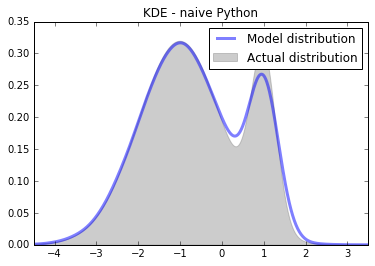

In [10]:
# Note: we are making a point of converting everything to lists
# before running the KDE function, in order to observe the performance
# of a "pure" Python implementation.

timer = time.time()
pdf = naive_kde(list(x), list(x_grid), bandwidth)
print('Time to complete model: {:.2f} seconds'.format(time.time() - timer))

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3, label='Model distribution')
plt.fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4, label='Actual distribution')
plt.title('KDE - naive Python')
plt.legend(loc='best')
plt.xlim(-4.5, 3.5)
plt.show()

## Vectorized Python implementation

This seems like somewhat of an unfair comparison, due to the double loop. 

The ability to use `numpy` to vectorize the inner loop makes a huge difference; `numpy` is made for these types of calculations and in fact is used in the sklearn version. 

For this simplified task (1-D Gaussian kernel), we can write a vectorized version in numpy that even outperforms the sklearn version for the values of n that we tried, given that we can avoid the overhead of checking inputs to handle different kernels as well as the setting up of a tree structure.

In [11]:
def vectorized_kde(x, x_grid, h):
    '''
    Calcalates the KDE PDF estimate, based on a Gaussian kernel.
    Inputs
    ----------
    x      : An array of iid random variables that are used to calculate the KDE estimate
    x_grid : An array of values along which to calculate the KDE estimate
    h      : Float, the bandwidth parameter for the KDE estimate
    Returns
    ----------
    An array of KDE estimates for all values of x_grid.
    '''    
    global N # number of iid random variables

    estimates = np.zeros(len(x_grid))
    
    for j, gridpt in enumerate(x_grid):
        val_in_sum = gaussian((x - gridpt)/h)  # returns vector of dim N
        estimates[j] = np.sum(val_in_sum) / (N * h)
    
    return estimates

Time to complete model: 1.34 seconds


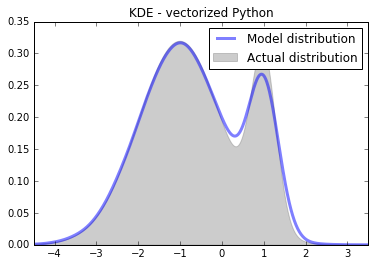

In [12]:
timer = time.time()
pdf = vectorized_kde(x, x_grid, bandwidth)
print('Time to complete model: {:.2f} seconds'.format(time.time() - timer))

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3, label='Model distribution')
plt.fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4, label='Actual distribution')
plt.title('KDE - vectorized Python')
plt.legend(loc='best')
plt.xlim(-4.5, 3.5)
plt.show()